In [0]:
import pandas as pd
import numpy as np
import cv2
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import joblib 

In [0]:
def load_data():
    # df_train = pd.read_csv(train_data_file)
    # df_test  = pd.read_csv(test_data_file) 
    # train_features = df_train.iloc[:,1:]
    # train_labels   = df_train.iloc[:,0]
    # train_features = np.array(train_features).astype(np.uint8)
    # test_features = np.array(test).astype(np.uint8) 
    # return train_features, train_labels, test_features
    dataset = keras.datasets.mnist
    (X_raw_train, y_train), (X_raw_test, y_test) = dataset.load_data()
    return (X_raw_train, y_train, X_raw_test, y_test)

In [0]:
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt

def shift_image(image, dx, dy):
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image

In [0]:
def preprocess(X_raw_train, X_raw_test):
  X_train = np.zeros((X_raw_train.shape[0], 108))
  X_test = np.zeros((X_raw_test.shape[0], 108))

  hog = cv2.HOGDescriptor((28, 28), (14, 14), (7, 7), (14, 14), 12)

  for n in range(len(X_raw_train)):
      X_train[n] = hog.compute(X_raw_train[n]).reshape(1, -1)
      
  for n in range(len(X_raw_test)):
      X_test[n] = hog.compute(X_raw_test[n]).reshape(1, -1)

  return X_train, X_test

In [0]:
# Classify the digits in X_test using the passed classifier 'clf'
def classify_Digits(clf, X_test):
  # Returns the probability vector of length 10 for each input in X_raw_test
  return clf.predict_proba(X_test)

In [0]:
# Take decision based on probability vector of each class
# cost_r: Cost of rejection (In our case we will mark it as empty or no digit = 0 in Sudoku)
# cost_w: Cost of wrong classification (In our case we will mark it as empty or no digit = 0 in Sudoku)
def take_decision(probabilities, cost_r=10, cost_w=20):
  assert cost_w != 0

  # Reference: https://www.cs.ubc.ca/~murphyk/Teaching/CS340-Fall07/dtheory.pdf
  pred_class = np.argmax(probabilities)
  if(probabilities[pred_class] > (1 - (cost_r/cost_w))):
    return pred_class

  # reject => No digit => 0 for our case
  return 0

In [7]:
X_raw_train, y_train, X_raw_test, y_test = load_data()

print("Creating Augmented Dataset...")
X_raw_train_augmented = [image for image in X_raw_train]
y_train_augmented = [image for image in y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,1), (-1,-1), (1,-1)):
     for image, label in zip(X_raw_train, y_train):
             X_raw_train_augmented.append(shift_image(image, dx, dy))
             y_train_augmented.append(label)

11493376/11490434 [==============================] - 0s 0us/step
Creating Augmented Dataset...


In [0]:
X_raw_train_augmented, y_train_augmented = np.array(X_raw_train_augmented), np.array(y_train_augmented)
X_train, X_test = preprocess(X_raw_train_augmented, X_raw_test)

# Gaussian Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

In [0]:
def train_GNB(X_train, y_train):
  clf = GaussianNB()
  clf.fit(X_train, y_train)
  return clf

### Testing Gaussian Naive Bayes

In [0]:
clf = train_GNB(X_train, y_train_augmented)
print(clf.classes_)

[0 1 2 3 4 5 6 7 8 9]


In [0]:
probabilities_mat = classify_Digits(clf, X_test)
y_pred = np.zeros((probabilities_mat.shape[0], ))
for i in range(len(probabilities_mat)):
  y_pred[i] = take_decision(probabilities_mat[i])

In [0]:
print(y_pred[0:10])
print(accuracy_score(y_pred, y_test))

[7. 2. 1. 0. 4. 1. 4. 9. 5. 7.]
0.915


In [0]:
# Save model
joblib.dump(clf, 'GNB.pkl')

['GNB.pkl']

# Random Forest model

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
def train_Random_Forest(X_train, y_train):
  rfc = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth = 20)
  rfc.fit(X_train, y_train)
  return rfc

### Testing Random Forest classifier

In [0]:
clf = train_Random_Forest(X_train, y_train_augmented)
print(clf.classes_)

[0 1 2 3 4 5 6 7 8 9]


In [0]:
probabilities_mat = classify_Digits(clf, X_test)
y_pred = np.zeros((probabilities_mat.shape[0], ))
for i in range(len(probabilities_mat)):
  y_pred[i] = take_decision(probabilities_mat[i])

In [0]:
print(y_pred[0:10])
print(accuracy_score(y_pred, y_test))

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9.]
0.9372


In [0]:
# Save model
joblib.dump(clf, 'RandomForest.pkl')

['RandomForest.pkl']

# Softmax Regression (Logistic regression for > 2 classes)

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
def train_SoftmaxRegression(X_train, y_train, max_iterations=100):
  clf = LogisticRegression(penalty='l2', dual=False, solver='lbfgs', multi_class='multinomial')
  clf.fit(X_train, y_train)
  return clf

### Testing softmax regression model

In [0]:
clf = train_SoftmaxRegression(X_train, y_train_augmented, max_iterations=1000)
print(clf.classes_)

[0 1 2 3 4 5 6 7 8 9]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
probabilities_mat = classify_Digits(clf, X_test)
y_pred = np.zeros((probabilities_mat.shape[0], ))
for i in range(len(probabilities_mat)):
  y_pred[i] = take_decision(probabilities_mat[i])

In [0]:
print(y_pred[0:10])
print(accuracy_score(y_pred, y_test))

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9.]
0.9668


In [0]:
# Save model
joblib.dump(clf, 'Softmax.pkl')

['Softmax.pkl']

# Gradient Boosted Softmax Regression (cross entropy loss)

In [0]:
import xgboost

In [0]:
def train_XGBoostSoftmax(X_train, y_train, max_depth=6, n_estimators=50):
  model = xgboost.XGBClassifier(objective="multi:softmax", booster="gbtree", max_depth=max_depth, n_estimators=n_estimators, num_classes=10)
  model.fit(X_train, y_train)
  return model

In [0]:
# clf = train_XGBoostSoftmax(X_train, y_train_augmented, max_depth=7, n_estimators=100)
clf = joblib.load("XGBOOST.pkl")
print(clf.classes_)

[0 1 2 3 4 5 6 7 8 9]


In [0]:
probabilities_mat = classify_Digits(clf, X_test)
y_pred = np.zeros((probabilities_mat.shape[0], ))
print(probabilities_mat[0])
for i in range(len(probabilities_mat)):
  y_pred[i] = take_decision(probabilities_mat[i])

[2.3678804e-05 2.8760120e-05 4.0040057e-05 6.5543842e-05 3.8886657e-05
 5.7991092e-05 1.9326704e-05 9.9962735e-01 3.2450516e-05 6.5977889e-05]


In [0]:
print(y_pred[0:10])
print(accuracy_score(y_pred, y_test))

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9.]
0.9753


In [0]:
# Save model
# joblib.dump(clf, 'XGBOOST.pkl')
clf.save_model("XGBOOST.bin")

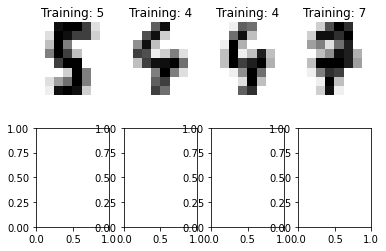

In [0]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[109:113]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [0]:
image = X_raw_train[1000]
shifted_image_down = shift_image(image, 0, 1)
shifted_image_left = shift_image(image, -1, 0)

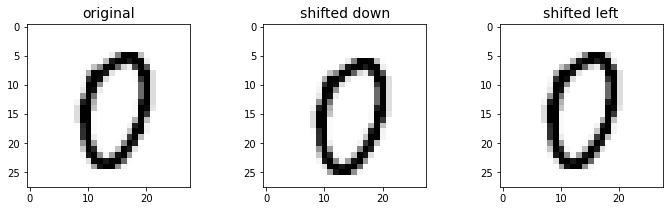

In [0]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(132)
plt.title("shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(133)
plt.title("shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")

In [0]:
clf_t = train_SoftmaxRegression(X_raw_train_augmented.reshape((-1, 28*28)), y_train_augmented, max_iterations=5000)
print(clf_t.classes_)

[0 1 2 3 4 5 6 7 8 9]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
probabilities_mat = classify_Digits(clf_t, X_test_2)
y_pred = np.zeros((probabilities_mat.shape[0], ))
for i in range(len(probabilities_mat)):
  y_pred[i] = take_decision(probabilities_mat[i])

In [0]:
print(y_pred[0:10])
print(accuracy_score(y_pred, y_test))

[7. 2. 1. 0. 4. 1. 4. 9. 6. 9.]
0.9035


# Testing on Computer typed hand labelled dataset

In [10]:
X_raw_train_2 = np.loadtxt("X_train.csv", dtype=np.uint8, delimiter=' ')
y_train_2 = np.loadtxt("y_train.csv", dtype=np.uint8, delimiter=' ')
print(X_raw_train_2.shape, y_train_2.shape)

X_raw_train_2 = np.reshape(X_raw_train_2, (-1, 28, 28))

print("Creating Augmented Dataset...")
X_raw_train_augmented_2 = [image for image in X_raw_train_2]
y_train_augmented_2 = [image for image in y_train_2]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,1), (-1,-1), (1,-1)):
     for image, label in zip(X_raw_train_2, y_train_2):
             X_raw_train_augmented_2.append(shift_image(image, dx, dy))
             y_train_augmented_2.append(label)

X_raw_train_augmented_2 = np.array(X_raw_train_augmented_2, dtype=np.uint8)
y_train_augmented_2 = np.array(y_train_augmented_2, dtype=np.uint8)

print(X_raw_train_augmented_2.shape, y_train_augmented_2.shape)

(313, 784) (313,)
Creating Augmented Dataset...
(2817, 28, 28) (2817,)


In [11]:
X_train_small, X_test_small = preprocess(X_raw_train_augmented_2[0:2000], X_raw_train_augmented_2[2000:])
y_train_small, y_test_small = y_train_augmented_2[0:2000], y_train_augmented_2[2000:]
print(X_train_small.shape)

(2000, 108)


In [12]:
print(X_train.shape, y_train_augmented.shape)
l = np.append(X_train, X_train_small, axis=0)
m = np.append(y_train_augmented, y_train_small)
print(l.shape, m.shape)

(540000, 108) (540000,)
(542000, 108) (542000,)


In [18]:
clf_sf_mod = train_SoftmaxRegression(l, m, max_iterations=5000)
print(clf_sf_mod.classes_)

[0 1 2 3 4 5 6 7 8 9]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
probabilities_mat = classify_Digits(clf_sf_mod, X_test_small)
y_pred = np.zeros((probabilities_mat.shape[0], ), dtype=np.uint8)
for i in range(len(probabilities_mat)):
  y_pred[i] = take_decision(probabilities_mat[i], 10, 15)

In [21]:
print(accuracy_score(y_pred, y_test_small))
print(y_pred[0:30])
print(y_test_small[0:30])

0.8727050183598531
[1 6 7 4 5 7 1 7 4 0 5 5 4 2 8 3 4 8 1 9 3 7 1 8 8 8 5 3 3 7]
[1 6 7 4 5 7 1 7 4 9 5 5 4 2 8 3 4 8 1 9 3 7 1 6 6 8 5 8 6 7]


In [0]:
# Save model
joblib.dump(clf_sf_mod, 'Softmax.pkl')

['Softmax.pkl']

In [0]:
clf_rf = train_Random_Forest(l, m)
print(clf_rf.classes_)

In [0]:
probabilities_mat = classify_Digits(clf_rf, X_test_small)
y_pred = np.zeros((probabilities_mat.shape[0], ), dtype=np.uint8)
for i in range(len(probabilities_mat)):
  y_pred[i] = take_decision(probabilities_mat[i], 10, 15)

In [0]:
print(accuracy_score(y_pred, y_test_small))
print(y_pred[0:10])
print(y_test[0:10])

0.0
[0 0 0 0 0 0 0 0 0 0]
[7 2 1 0 4 1 4 9 5 9]


In [0]:
print(accuracy_score(y_pred, y_test_small))
print(y_pred[0:10])
print(y_test[0:10])

0.0
[0 0 0 0 0 0 0 0 0 0]
[7 2 1 0 4 1 4 9 5 9]


In [0]:
clf_xg = train_XGBoostSoftmax(l, m, max_depth=8, n_estimators=100)

In [0]:
probabilities_mat = classify_Digits(clf_xg, X_test_small)
y_pred = np.zeros((probabilities_mat.shape[0], ), dtype=np.uint8)
for i in range(len(probabilities_mat)):
  y_pred[i] = take_decision(probabilities_mat[i], 10, 10)

In [32]:
print(accuracy_score(y_pred, y_test_small))
print(y_pred[0:30])
print(y_test_small[0:30])

0.8580171358629131
[1 5 7 8 5 7 1 7 6 0 5 5 2 2 8 3 4 8 1 9 3 7 1 8 6 8 5 3 3 7]
[1 6 7 4 5 7 1 7 4 9 5 5 4 2 8 3 4 8 1 9 3 7 1 6 6 8 5 8 6 7]
